## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

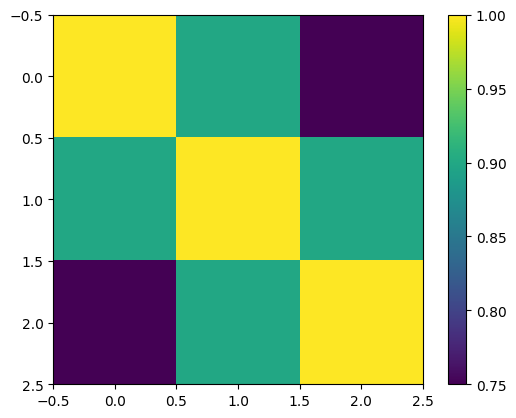

In [15]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


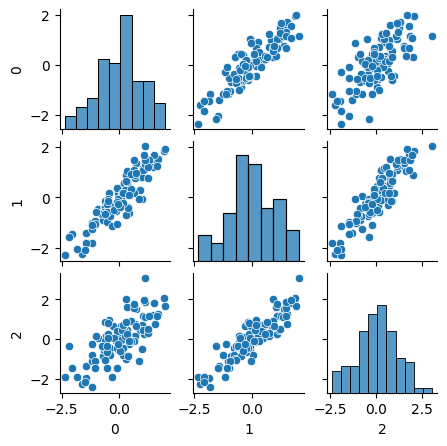

In [16]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

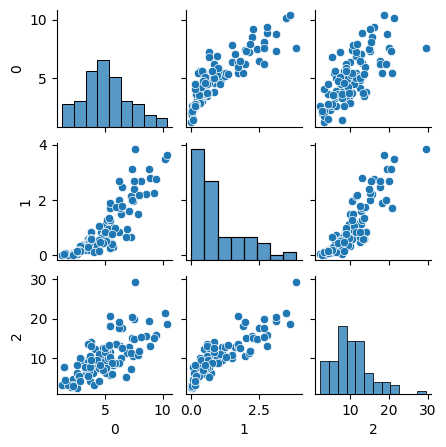

In [17]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [18]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_',
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)),
                           mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_',
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_',
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
                           mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()

# This probally produces a lot of warnings but it will run and provide inference

TypeError: Gamma.logcdf() got an unexpected keyword argument 'inv_beta'

In [19]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

NameError: name 'idata' is not defined

NameError: name 'idata' is not defined

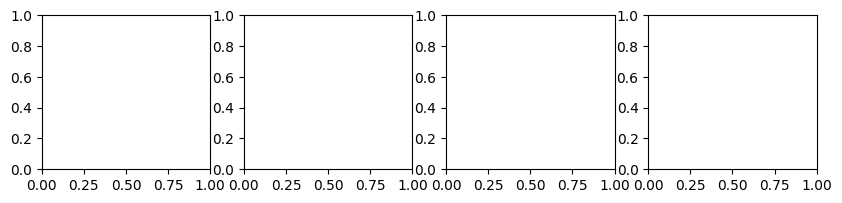

In [20]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

In [21]:
# QUESTION 1 ANSWER
import pymc as pm
import numpy as np
import arviz as az

# Step 1: Fit marginals independently
with pm.Model() as marginal_model:
    # Gamma for y[:,0]
    alpha0 = pm.HalfNormal('alpha0', sigma=10)
    obs0 = pm.Gamma('obs0', alpha=alpha0, beta=1, observed=y[:, 0])

    # Exponential for y[:,1]
    lam1 = pm.HalfNormal('lam1', sigma=10)
    obs1 = pm.Exponential('obs1', lam=lam1, observed=y[:, 1])

    # Chi-squared for y[:,2]
    nu2 = pm.HalfNormal('nu2', sigma=10)
    obs2 = pm.ChiSquared('obs2', nu=nu2, observed=y[:, 2])

    trace_marginals = pm.sample()


Output()

In [22]:
# Step 2: Transform observed data to latent normal space using posterior means
from scipy.stats import gamma, expon, chi2, norm

# Extract posterior mean parameters
alpha0_hat = trace_marginals.posterior['alpha0'].mean().values
lam1_hat = trace_marginals.posterior['lam1'].mean().values
nu2_hat = trace_marginals.posterior['nu2'].mean().values

# Probability integral transform (CDF then inverse normal)
z = np.zeros_like(y)
z[:, 0] = norm.ppf(gamma.cdf(y[:, 0], a=alpha0_hat, scale=1))
z[:, 1] = norm.ppf(expon.cdf(y[:, 1], scale=1/lam1_hat))
z[:, 2] = norm.ppf(chi2.cdf(y[:, 2], df=nu2_hat))

# Step 3: Estimate copula using Gaussian latent variables
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov('R', n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)

    pm.MvNormal('z', mu=np.zeros(3), chol=L, observed=z)

    trace_copula = pm.sample()


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/subtensor.py:2585: RuntimeWarning: invalid value 
encountered in add
  np.add.at(x, idx, y)

In [23]:
az.summary(trace_copula, var_names=["R_corr"], round_to=2)


/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"R_corr[0, 0]",1.00,0.00,1.00,1.00,0.0,NaN,2000.00,2000.00,NaN
"R_corr[0, 1]",0.89,0.02,0.85,0.93,0.0,0.0,1040.30,1218.69,1.0
"R_corr[0, 2]",0.68,0.05,0.59,0.77,0.0,0.0,1141.34,1331.04,1.0
"R_corr[1, 0]",0.89,0.02,0.85,0.93,0.0,0.0,1040.30,1218.69,1.0
"R_corr[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,1559.31,1679.72,1.0
"R_corr[1, 2]",0.89,0.02,0.85,0.92,0.0,0.0,1403.93,1638.72,1.0
"R_corr[2, 0]",0.68,0.05,0.59,0.77,0.0,0.0,1141.34,1331.04,1.0
"R_corr[2, 1]",0.89,0.02,0.85,0.92,0.0,0.0,1403.93,1638.72,1.0
"R_corr[2, 2]",1.00,0.00,1.00,1.00,0.0,0.0,1970.82,1995.17,1.0


A copula is a mathematical tool that allows us to model the dependency structure between random variables independently from their marginal distributions. In simpler terms: it lets each variable keep its own distribution (e.g., Gamma, Exponential, Chi-squared), while still capturing how they relate to each other.

n the original model (Chunk 4), the marginal distributions and the dependency structure are modeled simultaneously. Each observed variable is transformed inside the PyMC model to a latent normal variable using its inverse CDF (probit transformation). Then, a multivariate normal (Gaussian copula) is fitted directly on these latent variables. This approach is compact but can be computationally intense and harder to debug.

In  my two-pass model, it separates the estimation process into two distinct steps:

Pass 1: Estimate each marginal distribution (Gamma, Exponential, Chi-squared) independently using Bayesian inference.

Pass 2: Transform each variable to the standard normal scale using the estimated CDFs. Then fit a multivariate normal (i.e., Gaussian copula) on the transformed data to capture the dependency structure.

This modular design improves interpretability and often provides more stable inference, especially when the marginals are complex or non-Gaussian.

Copulas provide a framework for constructing multivariate GLM regressions, especially when the response variables have different types and distributions. To apply this approach, each response variable is first modeled individually using an appropriate GLM. This allows for flexibility in choosing different likelihoods based on the nature of each variable, for instance, using a Poisson regression for counts, a logistic regression for binary outcomes. After estimating each marginal model, the fitted values are transformed into a uniform scale via the cumulative distribution function (CDF) of the respective GLM. These uniform variables are then mapped onto a standard normal scale using the inverse normal CDF, effectively converting each variable into a latent Gaussian form. A multivariate copula, often a Gaussian copula, is then applied to these latent variables to model the dependency structure among the responses. This two-step process, separating the marginal modeling from the dependency modeling makes it possible to simulate or analyze complex joint behaviors without assuming that the marginals follow a multivariate normal distribution. In practical terms, this enables us to build rich, interpretable multivariate models that preserve the unique characteristics of each response while capturing their interdependencies in a coherent statistical framework.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Set seed and dimensions
np.random.seed(42)
n, p, m = 100, 10, 3
X = np.random.randn(n, p)

# Create sparse true beta
true_beta = np.zeros((p, m))
true_beta[1, :] = [2.5, 0, 1.0]
true_beta[3, :] = [-1.5, 2.0, 0]
true_beta[7, :] = [1.0, -2.0, 1.5]
Y = X @ true_beta + np.random.randn(n, m)

# Spike-and-slab multivariate regression model
with pm.Model() as spike_slab_model:
    # Binary inclusion indicators for each beta coefficient
    inclusion = pm.Bernoulli('inclusion', p=0.5, shape=(p, m))

    # Spike: tightly concentrated near 0
    spike = pm.Normal('spike', mu=0, sigma=0.1, shape=(p, m))

    # Slab: wide normal distribution
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(p, m))

    # Spike-and-slab prior
    beta = pm.Deterministic('beta', inclusion * slab + (1 - inclusion) * spike)

    # Independent noise per response
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    # Linear prediction
    mu = pm.math.dot(X, beta)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    # Sample from the posterior
    spike_trace = pm.sample(500, tune=250, target_accept=0.9, return_inferencedata=True)


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
with pm.Model() as diffuse_model:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(p, m))
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)
    diffuse_trace = pm.sample(500, tune=250, target_accept=0.9, return_inferencedata=True)


Output()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

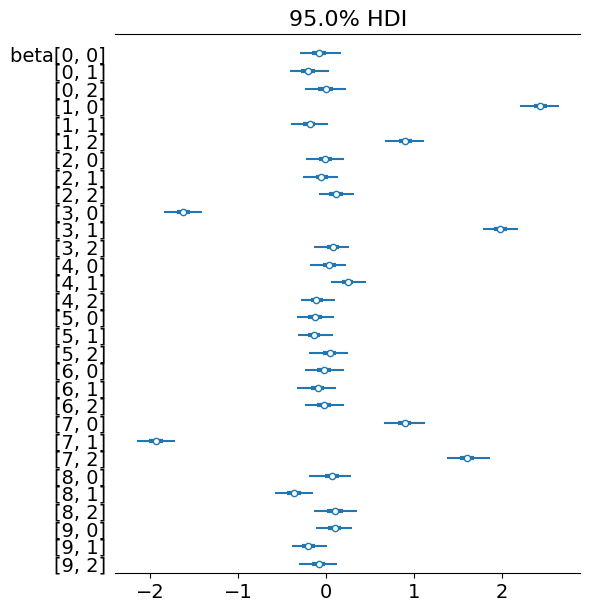

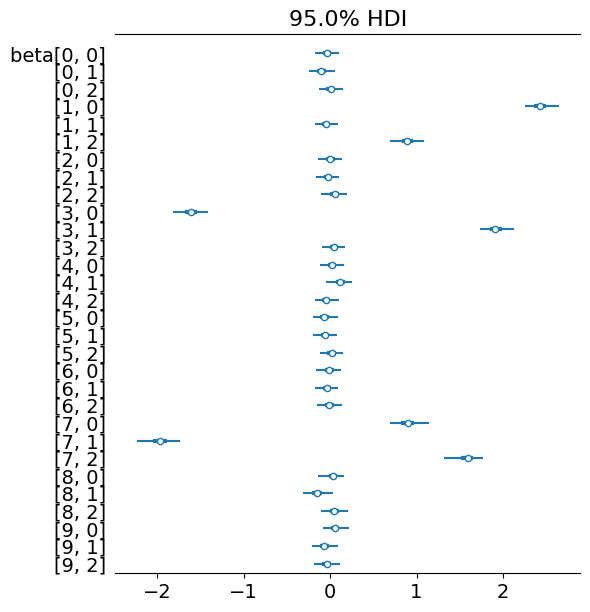

In [ ]:
az.plot_forest(diffuse_trace, var_names=["beta"], combined=True, hdi_prob=0.95)
az.plot_forest(spike_trace, var_names=["beta"], combined=True, hdi_prob=0.95)


Comparing the two models, the diffuse prior model yielded posterior intervals that were broader and included more non-zero coefficients, suggesting minimal regularization. In contrast, the spike-and-slab model selectively shrank many coefficients to near zero, with only a few showing strong posterior support, aligning with the sparse structure of the true data-generating process. Computationally, both models scale with
𝑛
n,
𝑝
p, and
𝑚
m, but spike-and-slab incurs higher cost due to discrete inclusion variables. As
𝑝
p or
𝑚
m increases, the number of latent inclusion variables grows, making inference slower and potentially harder to converge. Still, the interpretability gains from automatic variable selection can justify the cost in moderate dimensions.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



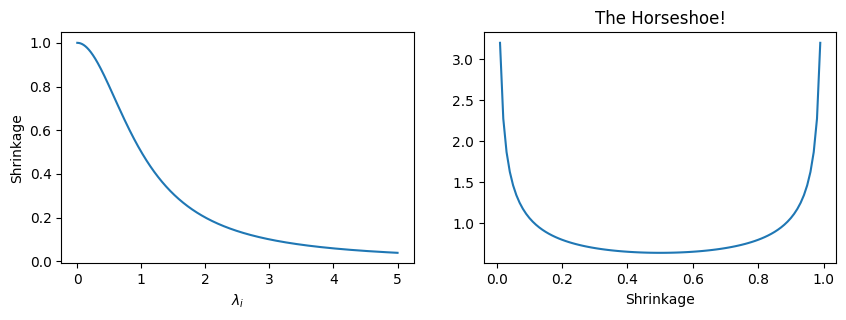

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

Output()

ERROR:pymc.stats.convergence:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


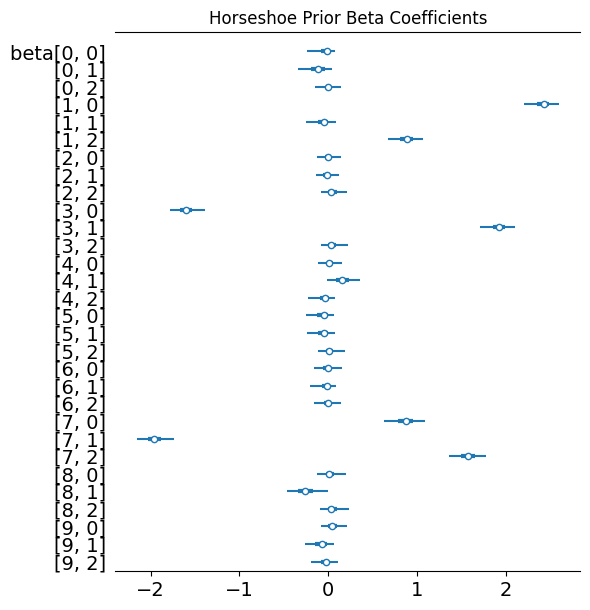

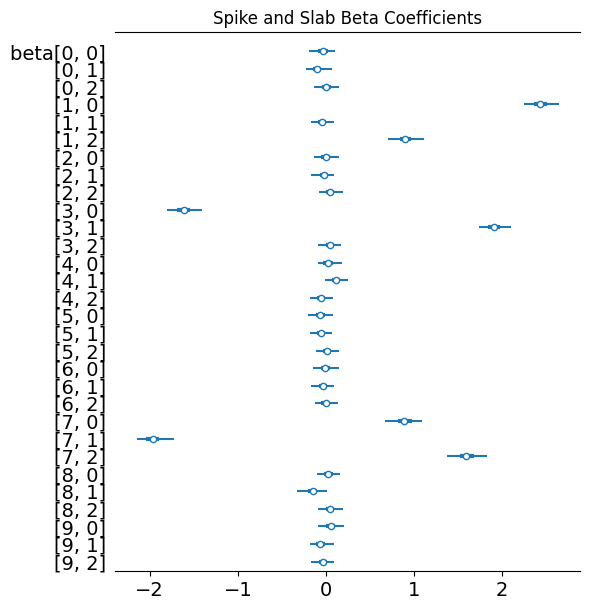

Output()

Output()

RMSE Horseshoe: <xarray.DataArray 'y_obs' ()> Size: 8B
array(0.97668561)
RMSE Spike and Slab: <xarray.DataArray 'y_obs' ()> Size: 8B
array(0.97919472)


In [26]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Data setup (re-use from Q2)
np.random.seed(42)
n, p, m = 100, 10, 3
X = np.random.randn(n, p)

# Sparse true coefficients
true_beta = np.zeros((p, m))
true_beta[1, :] = [2.5, 0, 1.0]
true_beta[3, :] = [-1.5, 2.0, 0]
true_beta[7, :] = [1.0, -2.0, 1.5]
Y = X @ true_beta + np.random.randn(n, m)

# Horseshoe prior model
with pm.Model() as horseshoe_model:
    tau_0 = 1.0  # global shrinkage scale

    # Local shrinkage per coefficient
    lam = pm.HalfCauchy('lam', beta=1, shape=(p, m))  # λ_i
    tau = pm.HalfCauchy('tau', beta=tau_0)            # τ shared across coefficients

    # Horseshoe scale
    sigma_w = pm.Deterministic('sigma_w', lam * tau)

    # Coefficients with horseshoe prior
    beta = pm.Normal('beta', mu=0, sigma=sigma_w, shape=(p, m))

    # Likelihood noise per outcome
    sigma = pm.HalfNormal('sigma', sigma=1, shape=m)

    # Linear predictor and likelihood
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    # Sample
    horseshoe_trace = pm.sample(500, tune=250, target_accept=0.9, return_inferencedata=True)

# Spike-and-slab multivariate regression model (from Q2)
with pm.Model() as spike_slab_model:
    inclusion = pm.Bernoulli('inclusion', p=0.5, shape=(p, m))
    spike = pm.Normal('spike', mu=0, sigma=0.1, shape=(p, m))
    slab = pm.Normal('slab', mu=0, sigma=10, shape=(p, m))
    beta_ss = pm.Deterministic('beta', inclusion * slab + (1 - inclusion) * spike)
    sigma_ss = pm.HalfNormal('sigma', sigma=1, shape=m)
    mu_ss = pm.math.dot(X, beta_ss)
    y_obs_ss = pm.Normal('y_obs', mu=mu_ss, sigma=sigma_ss, observed=Y)
    spike_trace = pm.sample(500, tune=250, target_accept=0.9, return_inferencedata=True)

# Visualization
az.plot_forest(horseshoe_trace, var_names=["beta"], combined=True)
plt.title("Horseshoe Prior Beta Coefficients")
plt.show()

az.plot_forest(spike_trace, var_names=["beta"], combined=True)
plt.title("Spike and Slab Beta Coefficients")
plt.show()

# Evaluation (RMSE)
ppc_horseshoe = pm.sample_posterior_predictive(horseshoe_trace, model=horseshoe_model, return_inferencedata=True)
ppc_spike = pm.sample_posterior_predictive(spike_trace, model=spike_slab_model, return_inferencedata=True)

y_pred_horseshoe = ppc_horseshoe.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])
y_pred_spike = ppc_spike.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])


rmse_horseshoe = np.sqrt(np.mean((y_pred_horseshoe - Y)**2))
rmse_spike = np.sqrt(np.mean((y_pred_spike - Y)**2))

print(f"RMSE Horseshoe: {rmse_horseshoe}")
print(f"RMSE Spike and Slab: {rmse_spike}")


Both priors are designed to promote sparsity in regression coefficients, but differ in how they shrink irrelevant features. The Horseshoe prior applies continuous shrinkage, allowing coefficients to be smoothly pulled toward zero, while the Spike-and-Slab prior uses binary inclusion variables that enforce exact zeros for many coefficients.

The posterior plots for the beta coefficients show that both models correctly identify the key non-zero predictors (particularly indices 1, 3, and 7 across outputs). The Horseshoe prior tends to keep more small-magnitude coefficients slightly away from zero, reflecting its continuous nature. In contrast, the Spike-and-Slab posterior is sharper and more binary, with many coefficients nearly exactly zero.

In terms of accuracy, both models performed similarly. The Horseshoe model achieved a slightly lower RMSE (0.9767) compared to the Spike-and-Slab model (0.9792), suggesting that both priors adequately capture the signal while filtering out noise. However, the Horseshoe prior may offer computational and modeling advantages by avoiding discrete latent variables, especially in higher dimensions.